# CORA (Basic Model)

1. First, create a new ```conda env```.
2. Install ```dgl```, ```dglgo```, ```torch_geometric```, and ```matplotlib```

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dgl.data import CoraGraphDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The following is implemented using Danish's GCN model which he sent us earlier in the quarter.

In [2]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, g, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl.nn.GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Load the datasets
cora_dataset = CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
g = cora_dataset[0]
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']

in_feats = features.shape[1]
h_feats = 64
num_classes = cora_dataset.num_classes
model = GCN(g, in_feats, h_feats, num_classes)

def train():
    # Train the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # for _ in range(200):
    model.train()
    logits = model(g, features)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        # print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [4]:
def save_embeddings_and_edges(dataset, dataset_name):
    model.eval()
    with torch.no_grad():
        embeddings = model(g, features)
    print(embeddings.shape)
    np.save(f'{dataset_name}_embeddings.npy', embeddings.detach().numpy())


    edge_index = g.edges()
    np.save(f'{dataset_name}_edge_index.npy', np.vstack((edge_index[0].numpy(), edge_index[1].numpy())))

In [5]:
train()
save_embeddings_and_edges(cora_dataset, 'cora')

torch.Size([2708, 7])


In [8]:
def test():
    data = cora_dataset[0].to(device)
    model.eval()
    out = model(data, features)
    pred = out.argmax(dim=1)

    incorrect_indices = (pred[data.ndata["test_mask"]] != data.ndata["label"][data.ndata["test_mask"]]).nonzero()

    print("Incorrect Predictions Indices:", incorrect_indices.flatten().tolist())

    acc = (pred[data.ndata["test_mask"]] == data.ndata["label"][data.ndata["test_mask"]]).sum().item() / data.ndata["test_mask"].sum().item()
    return acc

for epoch in range(0, 200):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Incorrect Predictions Indices: [5, 20, 25, 33, 56, 66, 84, 85, 88, 91, 92, 93, 94, 95, 99, 104, 126, 129, 132, 136, 137, 139, 146, 184, 185, 197, 202, 203, 212, 221, 229, 230, 249, 266, 268, 269, 273, 275, 277, 283, 284, 290, 295, 297, 299, 302, 304, 305, 306, 307, 308, 311, 314, 315, 317, 320, 323, 324, 325, 327, 328, 329, 330, 331, 333, 334, 336, 339, 350, 363, 370, 381, 389, 392, 393, 394, 395, 396, 397, 400, 403, 407, 411, 416, 417, 418, 420, 421, 442, 443, 444, 445, 446, 448, 458, 460, 462, 465, 466, 467, 469, 479, 480, 481, 482, 483, 486, 487, 500, 510, 521, 538, 547, 548, 551, 555, 559, 560, 566, 568, 574, 583, 584, 585, 589, 590, 591, 594, 598, 600, 601, 602, 605, 606, 608, 613, 615, 617, 622, 631, 633, 637, 638, 640, 641, 647, 649, 650, 652, 664, 665, 673, 674, 677, 680, 694, 697, 701, 702, 703, 705, 715, 717, 719, 724, 725, 728, 741, 748, 751, 754, 759, 760, 761, 762, 774, 776, 777, 781, 782, 786, 787, 789, 790, 802, 814, 821, 824, 834, 845, 857, 861, 864, 865, 869, 870, 872,

The following shows the 10 nodes with the highest degree.

threshold 0.011082379017362394


/Users/willcorcoran__/Classes/2023.2024/SINGH-RESEARCH/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


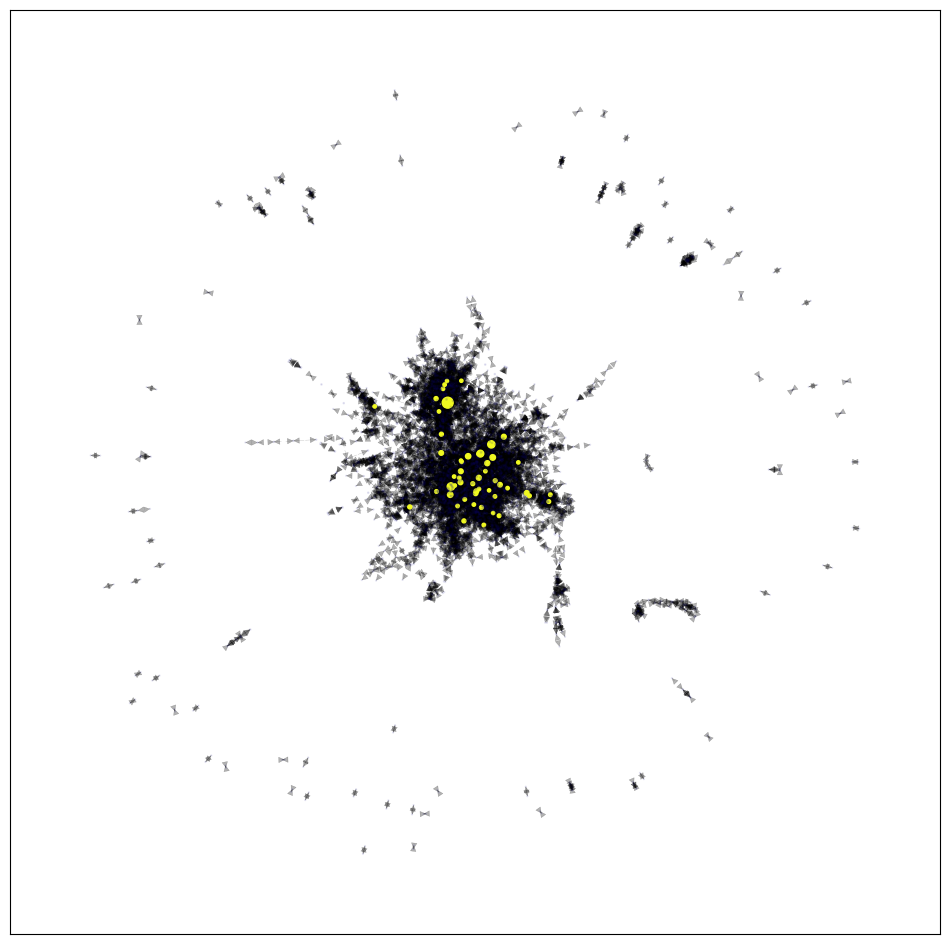

In [7]:
import networkx as nx
from dgl import to_networkx
import matplotlib.pyplot as plt

G = to_networkx(g)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[50]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

This shows me the node with the highest degree.

threshold 0.12412264499445881


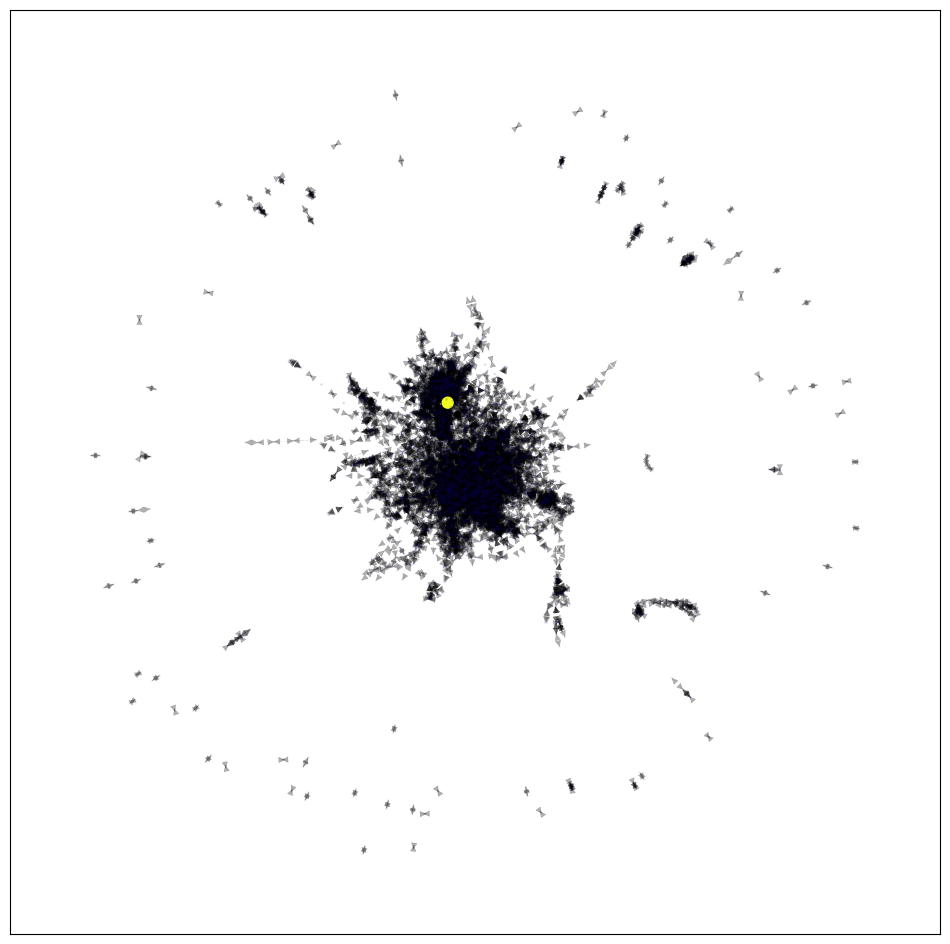

In [9]:
threshold = sorted(cent_array, reverse=True)[0]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()